# ELLIPTIC CURVES

## BASICS

In [1]:
!pip install py_ecc
!pip install libnum
!pip install galois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.9 MB/s eta 0:00:00


In [2]:
# The BN128 curve is used by the Ethereum precompiles to verify ZK proofs
# For the bn128 curve, the curve order is as follows:

from py_ecc.bn128 import curve_order
print(curve_order)

21888242871839275222246405745257275088548364400416034343698204186575808495617


In [3]:
# By “scalar multiplication” we really mean repeated addition.
from py_ecc.bn128 import G1, multiply, add, eq
print (G1)
print( eq( add(G1,G1), multiply(G1,2) ))

(1, 2)
True


In [4]:
# Generating all the valid points in an elliptic curve

from libnum import has_sqrtmod_prime_power, sqrtmod_prime_power

def generate_points( a, b, p) :
    x_coordinates = []
    y_coordinates = []

    for x in range (p) :
        y2 = ( (x**3) + (a*x) + b ) % p
        if has_sqrtmod_prime_power( y2, p, 1) :
            y1 = sqrtmod_prime_power( y2, p, 1)
            for y in y1 :
                y_coordinates.append(y)
                x_coordinates.append(x)

    return x_coordinates, y_coordinates

import matplotlib.pyplot as plt

def plot_points( coordinates ) :
    plt.scatter( coordinates[0], coordinates[1] )

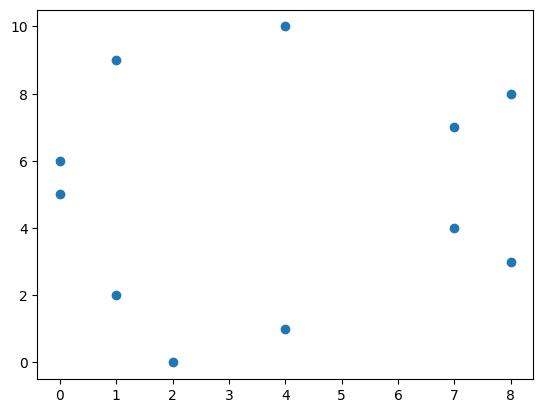

In [5]:
# Finding solutions for y^2 = x^3 + b mod(p)
plot_points( generate_points( 0,3,11 ) )

In [6]:
import galois

# Checking if a point lies on the curve or not
def on_curve (x,y,a,b,p) :
    GFp = galois.GF(p)
    if ( GFp (y%p) )**2 == ( ( GFp( x%p ) )**3 + (a * GFp( (x%p) )) + GFp(b%p) )  :
        return True
    return False


## ELLIPTIC CURVE ADDITION

In [7]:
# Adding a point to itself / Doubling of a point

def point_doubling( x,y,a,b,p ) :

    if not on_curve ( x,y,a,b,p ) :
        print ( (x,y), "does not lie on the elliptic curve" )
        return

    GFp = galois.GF(p)
    l = ( (3 * x**2) + a ) * ( GFp(1) / GFp ( (2*y)%p ) )
    X = l**2 - GFp( (2*x)%p )
    Y = l * ( GFp(x%p) - X ) - GFp (y%p)
    return (int(X),int(Y))


In [8]:
point_doubling(5,11,2,3,17)

(15, 5)

In [9]:
# Addition of two points m and n

def addition_of_points ( xm,ym,xn,yn,a,b,p ) :

    if not on_curve ( xm,ym,a,b,p ) :
        print ( (xm,ym), "does not lie on the elliptic curve" )
        return
    if not on_curve ( xn,yn,a,b,p ) :
        print ( (xn,yn), "does not lie on the elliptic curve" )
        return

    if xm == ym == None:
        return xn, yn
    if xn == yn == None:
        return xm, ym

    if xm==xn :
        if  ym==yn :
            return point_doubling( xm,ym,a,b,p )
        else :
            return None,None

    GFp = galois.GF(p)
    l = (ym-yn) * ( GFp(1) / GFp( (xm-xn) % p ) )
    x = l**2 - GFp( (xm+xn) % p )
    y = l * ( GFp(xm % p) - x ) - GFp( ym%p )
    return (int(x), int(y))


In [10]:
addition_of_points( 10,0,0,1,0,1,11 )

(2, 8)

In [11]:
# Obtaining all the points that satisfy the curve with the generator

def generate_points ( xg,yg,a,b,p ) :

    points = []
    x = xg
    y = yg

    while x!= None and y!= None :
        points.append( (x,y) )
        x,y = addition_of_points(x,y,xg,yg,a,b,p)

    return points


In [12]:
generate_points( 4,10,0,3,11 )

[(4, 10),
 (7, 7),
 (1, 9),
 (0, 6),
 (8, 8),
 (2, 0),
 (8, 3),
 (0, 5),
 (1, 2),
 (7, 4),
 (4, 1)]

In [13]:
# Homomorphism between modular addition and elliptic curve addition
# (x + y) mod curve_order == xG + yG

# The field modulus is the modulo we do the curve over. The curve order is the number of points on the curve.
# If you start with a point R and add the curve order o, you will get R back.
print( multiply(G1, 6) == multiply(G1, 6 + curve_order))


True


In [14]:
from py_ecc.bn128 import neg, is_inf, Z1

x = 12345678# generate the point
p = multiply(G1, x)

# invert
p_inv = neg(p)

# every element added to its inverse produces the identity element
print( is_inf(add(p, p_inv)))

# Z1 is just None, which is the point at infinity
print( Z1 is None )

True
True


In [15]:
# Basic zero knowledge proofs with elliptic curves

# Prover
secret_x = 5
secret_y = 10
x = multiply(G1, 5)
y = multiply(G1, 10)
proof = (x, y, 15)

# verifier
if multiply(G1, proof[2]) == add(proof[0], proof[1]):
    print("Statement is true")
else:
    print("Statement is false")

Statement is true


In [16]:
from py_ecc.bn128 import G2

print(G1)
print(G2)
# G2 is a pair of tuples. The first tuple is the two-dimensional x point and the second tuple is the two-dimensional y point.
# Both G1 and G2 have the same order (number of points on the curve)



(1, 2)
((10857046999023057135944570762232829481370756359578518086990519993285655852781, 11559732032986387107991004021392285783925812861821192530917403151452391805634), (8495653923123431417604973247489272438418190587263600148770280649306958101930, 4082367875863433681332203403145435568316851327593401208105741076214120093531))


In [17]:
from py_ecc.bn128 import curve_order

x = 10 # chosen randomly
print( eq(multiply(G2, x + curve_order), multiply(G2, x)) )
print( eq(multiply(G1, x + curve_order), multiply(G1, x)) )

True
True


## ELLIPTIC CURVE PAIRINGS

In [18]:
from py_ecc.bn128 import pairing

P = multiply(G1, 3)
Q = multiply(G2, 8)

R = multiply(G1, 24)
pairing(Q,P)

print( eq(pairing(Q, P), pairing(G2, R)))

True


In [19]:
# Elements in G_T behave like “powers” of a base.
# (b^x)*(b^y) = b^(x+y)

P_1 = multiply(G1, 2)
P_2 = multiply(G2, 3)

Q_1 = multiply(G1, 4)
Q_2 = multiply(G2, 5)

R_1 = multiply(G1, 13)
R_2 = multiply(G2, 2)

print( eq(pairing(P_2, P_1) * pairing(Q_2, Q_1), pairing(R_2, R_1)) )



True
